# Part 4. Unsupervised learning with time series - exercise

> Segmentation is all you need :)

In this exercises, we work with a dataset for Human Activity Recognition (HAR). 
Human activity recognition (HAR) systems are advanced machine learning (ML) workflows 
that automatically detect activities from motion data, captured e.g. by wearable 
devices such as smartphones. These devices contain multiple sensors that record 
human motion as acceleration, rotation and orientation in long time series (TS) data.

The name of today's dataset is *MOSAD - Mobile Sensing Human Activity Dataset* [[paper]](https://ceur-ws.org/Vol-3379/DARLI-AP_2023_2.pdf)
[[github]](https://github.com/ermshaua/mobile-sensing-human-activity-data-set). 
It is a multi-modal, annotated time series (TS) dataset that includes 14 recordings 
of 9 triaxial smartphone sensor measurements from 6 human subjects performing, in part, 
3 motion sequences in different locations. The dataset aims to facilitate the 
study of human behavior and the design of TS data mining technology to separate 
individual activities using low-cost sensors in wearable devices. The activities w
ere captured in a way to record meaningful human behavior in an unobtrusive and 
realistic setting, utilizing the built-in sensors of a smartphone. The transitions 
between activities in the recordings were annotated, and successive data points 
were sampled at a fixed rate of 50 Hz to enable machine learning technology to 
analyze the measurements and extract knowledge. The dataset design focused on 
capturing natural dynamics of human behavior with activities that are widely practiced, 
arranged in an order based on the places where they were recorded. The dataset 
includes measurements from all three (X, Y, and Z) sensor axes, annotated with 
activity transitions, resulting in a 9-dimensional multivariate TS and one list 
of change point positions per subject and routine.

Today you'll apply the knowledge acquired in part 4 to perform time series segmentation. 
Your task is building a segmentation model for this dataset, either for the whole 
dataset or for individual or groups of the time series contained there. Remember 
that you can also apply clustering techniques to do segmentation as long as you 
first perform a sliding-window version of your dataset.


## Download and load the data

In [1]:
%%capture
from fastai.data.external import untar_data
MOSAD_PATH = "https://github.com/vrodriguezf/mobile-sensing-human-activity-data-set/archive/refs/heads/main.zip"
path = untar_data(MOSAD_PATH, data='mosad')

In [5]:
import sys
sys.path.append(str(path/'src'))
sys.path.append(str(path/'benchmark'))
sys.path

['/home/victor/Github/sertemp/exercises',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/home/victor/.local/lib/python3.10/site-packages',
 '/home/victor/Github/kspdg/src',
 '/home/victor/Github/deepvats',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/victor/.fastai/mosad/main/src',
 '/home/victor/.fastai/mosad/main/src',
 '/home/victor/.fastai/mosad/main/benchmark']

In [8]:
from utils import load_mosad_dataset
from visualizer import plot_ts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from metrics import covering

df_mosad = load_mosad_dataset()
df_mosad.head()

,dataset,routine,subject,sensor,sample_rate,change_points,activities,time_series
0,Routine1_Subject1_X-Acc,1,1,X-Acc,50,"[738, 1722, 11356, 14124, 20558, 29858, 32736, 35194, 37310, 40450, 50104, 53254]","[descend stairs, climb stairs, vacuum, lie, iron, mop, sit, make bed, stand, slow walk, hang out laundry, walk, fold laundry]","[-0.1986, -0.454326, -0.5473, -0.496056, -0.4805, -0.575029, -0.4369, 0.24328, 0.01662, -0.1153, -0.285852, -0.484933, -0.564603, -0.488076, -0.3823, -0.2202, -0.008789, 0.308422, 0.060069, -0.0214, -0.339306, -0.244703, 0.287573, 0.343546, 0.3461, 0.172675, 0.04713, 0.104905, 0.128464, 0.0224, 0.2828, 0.32724, 0.5793, 0.6211, 0.6211, 0.5342, 0.726054, 0.853208, 0.871579, 0.909, 0.470276, 0.2575, -0.008709, 0.02623, 0.1001, 0.424734, 0.49309, 0.679464, 0.62838, 0.524, 0.2452, 0.272658, 0.376077, 0.355128, 0.3269, 0.756764, 1.051176, 1.016535, 0.648307, 0.5714, 0.2555, 0.426356, 0.740808, 0..."
1,Routine1_Subject1_X-Gyro,1,1,X-Gyro,50,"[738, 1722, 11356, 14124, 20558, 29858, 32736, 35194, 37310, 40450, 50104, 53254]","[descend stairs, climb stairs, vacuum, lie, iron, mop, sit, make bed, stand, slow walk, hang out laundry, walk, fold laundry]","[0.0174, 0.0358, 0.0431, 0.0358, 0.0168, 0.0083, 0.0181, -0.0003, 0.0126, 0.0321, 0.0382, 0.037, 0.0315, 0.0327, 0.0407, 0.0437, 0.015, -0.0131, 0.0168, 0.059, 0.1011, 0.1256, 0.125, 0.1085, 0.0908, 0.0718, 0.0547, 0.0455, 0.0107, -0.0186, -0.0204, 0.0119, 0.053675, 0.0791, 0.0669, 0.0138, -0.0632, -0.0852, -0.1108, -0.1224, -0.1371, -0.1585, -0.1725, -0.134, -0.0882, -0.0687, -0.0754, -0.0864, -0.0901, -0.0669, -0.0278, 0.015, 0.0743, 0.1274, 0.1421, 0.1103, 0.0602, 0.0474, 0.0712, 0.1292, 0.2227, 0.2258, 0.2031, 0.321, 0.274, 0.1689, 0.0993, -0.0308, -0.087, -0.1768, -0.3546, -0.569, -0...."
2,Routine1_Subject1_X-Mag,1,1,X-Mag,50,"[738, 1722, 11356, 14124, 20558, 29858, 32736, 35194, 37310, 40450, 50104, 53254]","[descend stairs, climb stairs, vacuum, lie, iron, mop, sit, make bed, stand, slow walk, hang out laundry, walk, fold laundry]","[-31.02, -30.84, -30.65, -30.58, -31.52, -30.73, -31.27, -30.5, -30.49, -30.52, -30.46, -30.8, -30.23, -29.77, -30.13, -28.92, -29.22, -29.51, -28.85, -28.84, -28.05, -28.24, -27.97, -27.75, -27.43, -27.13, -27.56, -27.33, -27.09, -27.11, -26.26, -26.92, -26.34, -26.12, -25.91, -25.71, -25.72, -25.36, -25.6, -25.48, -24.81, -25.0, -25.25, -25.19, -24.32, -24.4, -23.66, -23.85, -23.07, -22.51, -22.59, -22.04, -21.41, -20.52, -20.42, -19.83, -19.66, -18.53, -17.95, -16.87, -17.18, -16.27, -15.88, -15.14, -14.64, -14.75, -14.68, -14.79, -13.76, -13.66, -13.74, -13.12, -13.51, -12.63, -12.66, ..."
3,Routine1_Subject1_Y-Acc,1,1,Y-Acc,50,"[738, 1722, 11356, 14124, 20558, 29858, 32736, 35194, 37310, 40450, 50104, 53254]","[descend stairs, climb stairs, vacuum, lie, iron, mop, sit, make bed, stand, slow walk, hang out laundry, walk, fold laundry]","[-0.0161, -0.100877, -0.1434, -0.13972, -0.0819, 0.002867, 0.1549, 0.047431, 0.021801, 0.0274, 0.020719, 0.039185, 0.063037, 0.07705, 0.0811, -0.0111, -0.041098, -0.001461, 0.060462, 0.0713, 0.106367, 0.108597, 0.159506, 0.172336, 0.173, 0.107775, 0.220878, 0.205537, 0.16549, 0.1367, 0.05, 0.197192, 0.3188, 0.2492, 0.2492, -0.0188, -0.092232, -0.051774, -0.073151, -0.1254, 0.01164, 0.1094, 0.365145, 0.501513, 0.5732, 0.377307, 0.331303, 0.233584, 0.191729, 0.1887, 0.2158, 0.272864, 0.244444, 0.266348, 0.3025, 0.265272, 0.182315, 0.202214, 0.321864, 0.3664, 0.6426, 0.057795, -1.115988, -1.2..."
4,Routine1_Subject1_Y-Gyro,1,1,Y-Gyro,50,"[738, 1722, 11356, 14124, 20558, 29858, 32736, 35194, 37310, 40450, 50104, 53254]","[descend stairs, climb stairs, vacuum, lie, iron, mop, sit, make bed, stand, slow walk, hang out laundry, walk, fold laundry]","[-0.0525, -0.0568, -0.0482, -0.0012, 0.0153, 0.0122, 0.0306, 0.0941, 0.1222, 0.1252, 0.1289, 0.1326, 0.1124, 0.1234, 0.1381, 0.139636, 0.2004, 0.2987, 0.3415, 0.3018, 0.2181, 0.1875, 0.2132, 0.2627, 0.3225, 0.2993, 0.3018, 0.3543, 0.3977, 0.4178, 0.43

In [9]:
"""Adapted from aeon"""
def plot_series_with_change_points(y, change_points, title=None, segment_names=None, font_size=16):
    """Plot the time series with the known change points.

    Parameters
    ----------
    y: array-like, shape = [n]
        the univariate time series of length n to be annotated
    change_points: array-like, dtype=int
        the known change points
        these are highlighted in the time series as vertical lines
    title: str, default=None
        the name of the time series (dataset) to be annotated
    font_size: int, default=16
        for plotting
    segment_names: list of str, default=None
        names for the segments to be used in the legend

    Returns
    -------
    fig : matplotlib.figure.Figure
    ax : plt.Axis

    """
    true_cps = np.sort(change_points)
    segments = [0] + list(true_cps) + [y.shape[0] - 1]

    fig, ax = plt.subplots(figsize=plt.figaspect(0.25))
    for idx in np.arange(0, len(segments) - 1):
        label = segment_names[idx] if segment_names is not None and len(segment_names) > idx else f"Segment {idx}"
        ax.plot(
            range(segments[idx], segments[idx + 1] + 1),
            y[segments[idx] : segments[idx + 1] + 1],
            label=label
        )

    lim1 = plt.ylim()[0]
    lim2 = plt.ylim()[1]

    colors = plt.cm.rainbow(np.linspace(0, 1, len(true_cps)))
    for i, idx in enumerate(true_cps):
        ax.vlines(idx, lim1, lim2, linestyles="--", color=colors[i])

    plt.legend(loc="best")

    # Set the figure's title
    if title is not None:
        fig.suptitle(title, fontsize=font_size)

    return fig, ax

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

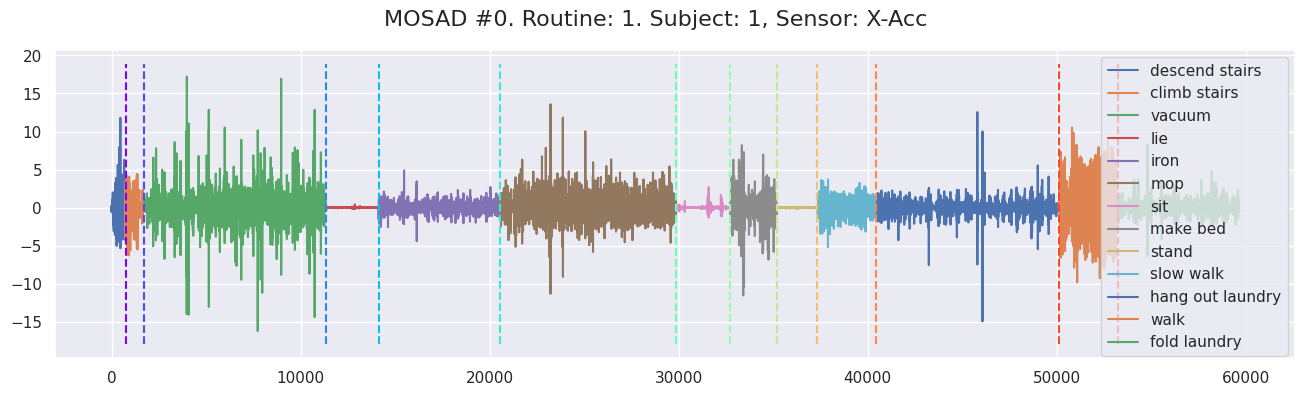

In [10]:
i = 0
plot_series_with_change_points(y=df_mosad.time_series[i], 
                               change_points=df_mosad.change_points[i], 
                               title=f'MOSAD #{i}. Routine: {df_mosad.routine[i]}. Subject: {df_mosad.subject[i]}, Sensor: {df_mosad.sensor[i]}',
                               segment_names=df_mosad.activities[i])

In [12]:
predicted_cps = np.random.choice(range(0, len(df_mosad.time_series[i])), size=5, replace=False)
covering({0: df_mosad.change_points[i]}, predicted_cps, n_obs=len(df_mosad.time_series[i]))


0.39709272786934746